# Plan for this notebook
We will attempt to attack the discriminator.


# Technicalities & getting the data

Don't forget to change the runtime to include a GPU (Runtime -> Change runtime type)

In [53]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

Also, let's mount the Google Drive to save the the models. As you surely remember, the filesystem in a colab runtime is not pesistent.

In [54]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [55]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

Get the data:

In [56]:
df = pd.read_csv('https://query.data.world/s/nap7jvxtupud25z5ljvtbzzjjsqqay')
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_774,column_775,column_776,column_777,column_778,column_779,column_780,column_781,column_782,column_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
target = pd.read_csv('https://query.data.world/s/sn3dximsq5sw3a6wtqoc3okulevugz')
target.head()

,column_0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [58]:
from sklearn.model_selection import train_test_split
train, test, tar_train, tar_test = train_test_split(df, target, test_size=0.2, random_state=12345)

In [59]:
train = np.array(train, dtype='float')
test = np.array(test, dtype='float')
tar_train = np.array(tar_train, dtype='float')
tar_test = np.array(tar_test, dtype='float')

In [60]:
train= train.reshape((-1, 1, 28, 28)) / 255.
test= test.reshape((-1, 1, 28, 28)) / 255.

Let's see what we've get. Here's a function to plot a (optionally random) subset of images:

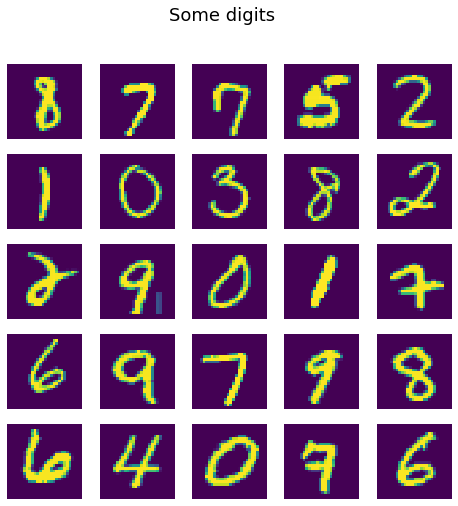

In [61]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                title: str="",
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                interpolation="none")
      ax.set_axis_off()

  figure.suptitle(title, fontsize=18)
  return figure

plot_images(train, title="Some digits");

# Building the GAN
Finally, let's import torch and define the Reshape layer (same as in the introduction to PyTorch):

In [62]:
import torch
from torch import nn
from torch.nn.functional import logsigmoid

class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

### Generator & Discriminator

In [63]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator_other.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator_other.pt')

In [64]:
CODE_SIZE = 256
DROPOUT_RATE = 0.1

try:
  generator = torch.load(GENERATOR_FILE)
  discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
 print('FUUUUUU!')


In [65]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, device="cuda")
  return generator(noise)

In [66]:
# A small check that the generator output has the right size
test_generated_data = sample_fake(1)
assert tuple(test_generated_data.shape[1:]) == train.shape[1:]

In [67]:
# As advertised, a discriminator outputs a single number per image
assert discriminator(test_generated_data).shape == (1, 1)

Check that generator and discriminator complexity is roughly the same:

In [68]:
def get_n_params(model):
  return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(generator))
print('discriminator params:', get_n_params(discriminator))

generator params: 1022145
discriminator params: 1349297


Then, we need a function to sample real and fake images:

In [69]:
def sample_images(batch_size):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda").float()

Let's have a look what we can generate before any training:

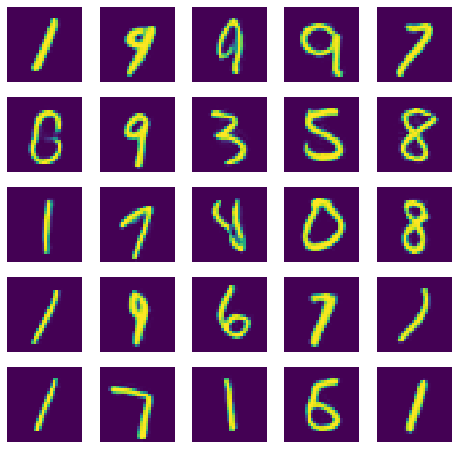

In [70]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plot_images(imgs.clip(0, 1));

Unsurprisingly, the core loss math is the same as we had in the 1D GAN. And we add some noise. Question to you: what for? In this notebook, we want to reach overfitting.

In [92]:
noise_power = 0
gradient_penalty = 0.000

def generator_loss(fake):
  return -logsigmoid(discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()
  
  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

Let's do some more set-up and run the learning process:

In [93]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)

In [132]:
VALIDATION_INTERVAL = 200
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 1
BATCH_SIZE=128

In [136]:
losses = np.zeros(100)

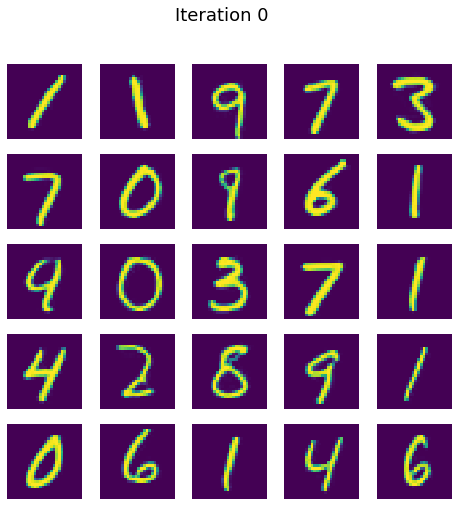

In [137]:
from IPython.display import clear_output
for i in range(100):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  gen_scheduler.step()
  disc_scheduler.step()
  
  # Several discriminator updates per step:
  for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) 
                                   #discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()

  # Pass the discriminator loss to Tensorboard for plotting 
  #summary_writer.add_scalar("discriminator loss", discriminator_loss_this_iter,
   #                          global_step=i)

  # Now it's generator's time to learn:
  #generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))
  #summary_writer.add_scalar("generator loss", generator_loss_this_iter,
  #                          global_step=i)
  #optimizer_generator.zero_grad()
  #generator_loss_this_iter.backward()
  #optimizer_generator.step()
  losses[i] = discriminator_loss_this_iter

  if i % SAVE_INTERVAL == 0:
    torch.save(generator, GENERATOR_FILE)
    torch.save(discriminator, DISCRIMINATOR_FILE)
    
  if i % VALIDATION_INTERVAL == 0:
    clear_output(wait=True)
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
    plt.show();

We've taken satisfactory results. Those digits seem very realistic.

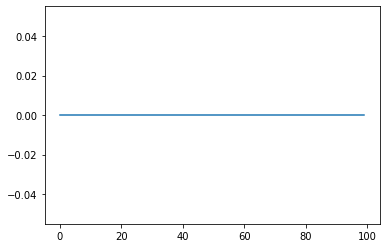

In [138]:
plt.plot(losses)

# Trying to attack

In [139]:
n1 = 500
n2 = 500

In [140]:
sample_train = train[np.random.permutation(train.shape[0])[0:n1]]
sample_test = test[np.random.permutation(test.shape[0])[0:n2]]

In [141]:
our_sample = np.concatenate((sample_train, sample_test), axis=0)

In [142]:
(our_sample[500+45] == sample_test[45]).all()

True

In [143]:
our_sample.shape

(1000, 1, 28, 28)

In [144]:
labels = np.array([x < n1 for x in range(n1+n2)], dtype=int)

In [145]:
discriminator.eval()
ans = discriminator(torch.tensor(our_sample).float().cuda()).cpu().detach().numpy().reshape(-1)

In [146]:
df = pd.DataFrame({'disc':ans, 'label':labels})

In [147]:
df.head()

,disc,label
0,163.891434,1
1,117.651550,1
2,199.088135,1
3,127.691040,1
4,208.897644,1


In [148]:
df.sort_values(by='disc', ascending=False).iloc[0:n1]['label'].sum() / n1

0.494

In [149]:
df.sort_values(by='disc', ascending=False)

,disc,label
69,302.174072,1
710,275.146881,0
88,271.542267,1
216,259.201996,1
937,257.846771,0
...,...,...
223,85.800827,1
634,84.515999,0
713,84.512596,0
8,84.030289,1


In [150]:
#random_choice
df['label'].sample(n=n1).sum() / n1

0.47

The discriminator is too stupid to show overfitting. 